<a href="https://colab.research.google.com/github/vmartinezarias/Workflow-to-optimize-spatial-sampling-in-ecoacoustic-studies/blob/main/Martinez_Arias_et_al_2025_Workflow_to_optimize_spatial_sampling_in_ecoacoustic_studies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix S10: Workflow to optimize spatial sampling in ecoacoustic studies

Supporting information for:

Title: A workflow to optimize spatial sampling in ecoacoustic studies

Journal: Landscape Ecology

Authors: Martínez-Arias, V. M.1; Paniagua-Villada1, C.; Guerrero, M.J.; Daza, J. M.1

Author affiliations at the time the work was conducted:
1. Grupo Herpetológico de Antioquia, Calle 70 No. 52 - 21, Postal Code 050010, Medellín, Colombia.


Present affiliations (if different):

*Corresponding author: Victor M. Martínez Arias
Email: vmanuel.martinez@udea.edu.co
Tel: 573116797846

# DESCRIPTION

To ensure accurate and representative sampling in heterogeneous landscapes, we propose a structured, landscape-based workflow for ecoacoustic sub sampling. This workflow integrates spatial segmentation, sampling point selection, and statistical validation to assess how well different sub sampling strategies reproduce the spatial structure of the full landscape dataset.

By default, the CRS is EPSG: 32618. However user can configure it on the required chunks.

Our workflow consists of the following steps:

# STEP I: PREPARATION

Our workflow begins by defining the ecoacoustic recording parameters and select a landscape proxy. This may need the process of acquiring geospatial data, which may include composite images or spectral indices.

The user should consider the device’s effective recording range (r) and select a representative bounding box that captures landscape variability of the evaluated study area.

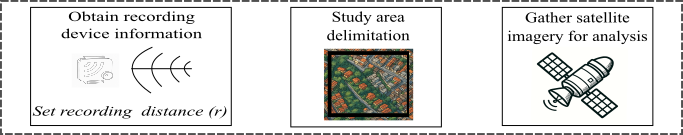



In [ ]:
!pip install folium geopandas openpyxl
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')



# STEP II: LANDSCAPE PROXIES SELECTION

Users should begin by selecting a landscape proxy to guide spatial stratification. We classified landscape proxies based on the concept of ecotope (Radoux et al. 2019; Farina 2022; Francis et al. 2022), distinguishing two types:

Continuous: These proxies consist of homogeneous landscape units and include gradient-based measures. Each ecotope corresponds to a pixel in the landscape proxy, and all ecotopes are of equal size. In our case, we used a fusion of several spectral indices, although users may choose any type of satellite-derived data.

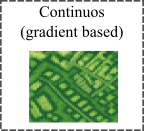

Discrete: These proxies are defined, typically non-homogeneous, and non-gradient units. This approach applies to land cover classifications, where each ecotope corresponds to a specific land cover unit. In our workflow, we constructed this proxy using a semi-automatic reclassification, although any thematic-based tessellation can be used.

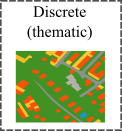


### Load and rescale your continuous landscape proxy (1-100)
Here the user can upload his landscape proxy. This can be a fusion, and spectral index, etc.
The chunk will escalate the proxy between 1-100 as preparation for watershed an slic algorithms.


In [ ]:
 Install required package (only needed in Colab or if rasterio isn't installed)
# Uncomment this line if needed:
# !pip install rasterio

#  Import required libraries
import rasterio
import os
from google.colab import files  # Only if running in Google Colab
import tempfile

# 📥 Upload raster file
uploaded = files.upload()  # User selects a .tif file

# Get the uploaded file path
input_path = list(uploaded.keys())[0]
print(f"Input raster: {input_path}")

# 📁 Define output path
output_path = f"rescaled_{os.path.basename(input_path)}"

# ⚙️ Rescaling function
def rescale_raster(input_path, output_path, new_min=1, new_max=100):
    with rasterio.open(input_path) as src:
        data = src.read(1).astype(float)
        mask = data != src.nodata
        data[mask] = (new_max - new_min) * (data[mask] - data[mask].min()) / (data[mask].max() - data[mask].min()) + new_min
        profile = src.profile
        profile.update(dtype='float32', nodata=src.nodata)

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data, 1)

# Apply rescaling
rescale_raster(input_path, output_path)
print(f"✅ Rescaled raster saved as: {output_path}")


# STEP III: TESSELLATION OF THE LANDSCAPE
In this step, the user subdivides the landscape into spatial units based on the selected proxy. In our case, we used two algorithms: SLIC and Watershed to generate the tessellations. However, the workflow can also be applied to any other existing tessellation method the user deems appropriate, so if the user has another, they can jump onto the following step.

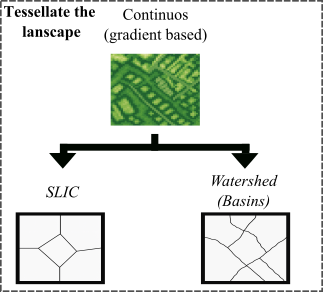

Most watershed algorithms generate only “Basins,” while the “Halfbasins” tessellation is, to the best of our knowledge, exclusive to the r.watershed algorithm available in the GRASS/QGIS environment. For this reason, halfbasins are not included in the illustrated version of our workflow.

For the tiles generation, user probably will need to consider an area’s tile parameter that should be based on device’s recording range. In the case of used Watershed and SLIC algorithms, we employed a circle area derived from a range of recording of 200m, obtained the parameter Ai = 125644m2. In watershed, this area value was directly introduced in the algorithm preparation, scaled to the used raster’s pixel resolution (100m2). In the used SLIC algorithm we took the bounding box area, and divide it by Ai to determine a value named “K”, which consists in the number of expected tiles. User should consider that the use of the parameter Ai may chance according to the selected algorithm, and this parameter is highly relevant to guarantee spatial independence.

## Basins & Half-basins

This analyses must be performed using the algoritm r.watershed for qgis


### Instal required packages and GRASS GIS environment.

In [ ]:
!sudo add-apt-repository ppa:ubuntugis/ubuntugis-unstable -y && \
sudo apt-get update -y && \
sudo apt-get install grass grass-core grass-dev libgdal-dev libgeos-dev libproj-dev libsqlite3-dev -y



### Check Grass Version

In [ ]:
!grass --version
!ls /usr/lib/ | grep grass

In [ ]:
# Install grass-session (and other GRASS GIS Python bindings if needed)
!pip install geopandas grass-session rasterio


### Import Packages

In [ ]:
import os
import math
from grass_session import Session
import grass.script as gs
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from shapely.geometry import box
import shutil


### Define parameters
We use 200 meters as audimoth radius. Please, note this can change according to the device or user's requirements. Also, note the user need to configure pixel size of the raster file!!!

In the first lines user can change the epsg code. MUST BE a projected system. Althought most of epsg should work just fine, we strongly recommended the use of UTM based systems.  

In [ ]:
import os
import shutil
import math
from google.colab import files

# --- 1. EPSG selection ---
epsg_code = 32618  # Default: UTM 18N

# --- 2. Minimum Basin Area Calculation ---
radius_meters = 200
min_basin_area_m2 = math.pi * (radius_meters ** 2)
pixel_area_m2 = 10 * 10
min_basin_area_pixels = int(min_basin_area_m2 / pixel_area_m2)

print(f"🧮 Minimum Basin Area:")
print(f"   - In square meters: {min_basin_area_m2:.2f}")
print(f"   - In pixels (10m resolution): {min_basin_area_pixels}")

# --- 3. Upload raster ---
uploaded = files.upload()
input_raster_path = list(uploaded.keys())[0]
print(f"✅ Raster uploaded: {input_raster_path}")

# Derive name without extension
base_name = os.path.splitext(os.path.basename(input_raster_path))[0]

🧮 Minimum Basin Area:
   - In square meters: 125663.71
   - In pixels (10m resolution): 1256


Saving AndeanRural_PC1_scaled.tif to AndeanRural_PC1_scaled.tif
✅ Raster uploaded: AndeanRural_PC1_scaled.tif


### Run GrassGIS

In [ ]:
from grass_session import Session
import grass.script as gs
from google.colab import files

# --- Delete previous GRASS location if exists ---
grass_location_path = "/tmp/temp_location"
if os.path.exists(grass_location_path):
    shutil.rmtree(grass_location_path)
    print(f"Previous GRASS location deleted: {grass_location_path}")

# --- Start GRASS GIS session and run watershed analysis ---
with Session(gisdb="/tmp", location="temp_location", mapset="PERMANENT", create_opts=f"EPSG:{epsg_code}"):
    print(" GRASS GIS session started.")

    # Import raster
    gs.run_command("r.in.gdal", input=input_raster_path, output="dem", overwrite=True)
    gs.run_command("g.region", raster="dem")

    # r.watershed: Basins and Halfbasins
    print("⚙️ Running r.watershed...")
    gs.run_command(
        "r.watershed",
        elevation="dem",
        basin="basins",
        half_basin="halfbasins",
        threshold=min_basin_area_pixels,
        flags='b',
        overwrite=True
    )

    # Output file names based on uploaded raster name
    output_basins_raster = f"{base_name}_basins.tif"
    output_halfbasins_raster = f"{base_name}_halfbasins.tif"

    # Export rasters
    print(" Exporting rasters...")
    gs.run_command("r.out.gdal", input="basins", output=output_basins_raster,
                   format="GTiff", type="UInt32", createopt="COMPRESS=LZW", overwrite=True)
    gs.run_command("r.out.gdal", input="halfbasins", output=output_halfbasins_raster,
                   format="GTiff", type="UInt32", createopt="COMPRESS=LZW", overwrite=True)

# --- Trigger downloads ---
print(" Downloading files...")
files.download(output_basins_raster)
files.download(output_halfbasins_raster)

print(" Process completed. Files ready for download.")


### Export tessells as GeoJSONS

In [ ]:
import os
import geopandas as gpd
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
from google.colab import files

#upload
uploaded = files.upload()
input_raster_path = list(uploaded.keys())[0]
print(f"✅ Raster uploaded: {input_raster_path}")

base_name = os.path.splitext(os.path.basename(input_raster_path))[0]
output_geojson = f"{base_name}.geojson"

# --- Raster to Vector GeoJSON ---
def raster_to_vector(raster_path, output_path):
    with rasterio.open(raster_path) as src:
        image = src.read(1).astype(rasterio.int32)
        mask = image != src.nodata

        results = (
            {"properties": {"value": v}, "geometry": shape(s)}
            for i, (s, v) in enumerate(
                shapes(image, mask=mask, transform=src.transform)
            )
            if v != 0
        )

        gdf = gpd.GeoDataFrame.from_features(results, crs=src.crs)
        gdf = gdf.to_crs(epsg=epsg_code)
        gdf.to_file(output_path, driver="GeoJSON")

        print(f"✅ Vectorization complete → {output_path}")

# --- Execute ---
raster_to_vector(input_raster_path, output_geojson)

# --- download ---
files.download(output_geojson)


## SLIC

### Install R environment and required packages
Here we need to install all dependencies for the SLIC. We implemented the analyses using the Supercells Package (See Supplementary information S1). You can change the Ncpus parameter, according to the number of cpus of your colab session. However, this may take a while, grab a coffe (~10 minutes).

In [ ]:
# Check available number of cores HERE!
import multiprocessing
multiprocessing.cpu_count()

In [ ]:
# Installing the R essentials and setting up R in Colab for the user
!apt-get install -y libgdal-dev libproj-dev libgeos-dev libudunits2-dev
!R -e "Ncpus <- parallel::detectCores(); install.packages(c('sf', 'terra', 'supercells', 'reticulate'), dependencies=TRUE, Ncpus=96)"



### Upload landscape proxy and define parameters

In [ ]:
# Upload raster and define parameters
import os
from google.colab import files
import math

# Upload .tif raster file
uploaded = files.upload()
uploaded_path = list(uploaded.keys())[0]
print(f"✅ Raster uploaded: {uploaded_path}")

# EPSG code (default: 32618 = UTM Zone 18N)
epsg_code = 32618

# Parameters: Recorder area radius in meters
radius_meters = 200
recorder_area_m2 = math.pi * (radius_meters ** 2)

# Save parameters to text file (with newline to avoid warning)
with open("params_for_r.txt", "w") as f:
    f.write(f"{uploaded_path},{epsg_code},{recorder_area_m2}\n")

print("✅ Parameters saved. Proceed to the next cell to run SLIC segmentation.")


### RUN SLIC algorithm using SUPERCELLS package in R

You may be consider the following parameters in supercells:

compactness:	controls how regular or compact the resulting segments are. A low value (i.e. 1) prioritizes spectral similarity; a high value emphasizes spatial compactness. Think of it as the trade-off between color similarity and spatial closeness.
avg_fun = "mean":	Defines the aggregation function used to compute the mean value of raster cells within each segment. You can also use "median" or custom functions, depending on your aims.


For more information, please check the Supercells R package guides (online up to 20250617:
https://cran.r-project.org/web/packages/supercells/index.html

https://github.com/Nowosad/supercells

In [ ]:
#activate R Environment
%load_ext rpy2.ipython

In [ ]:
%%R

# Load required libraries
library(supercells)
library(terra)
library(sf)

# Read parameters from Python
params <- readLines("params_for_r.txt")
parts <- strsplit(params, ",")[[1]]
input_raster_path <- parts[1]
epsg_code <- as.numeric(parts[2])
recorder_area_m2 <- as.numeric(parts[3])

# Load landscape proxy raster
landscape_proxy <- rast(input_raster_path)
cat("✅ Raster loaded successfully.\n")

# Calculate raster area and estimated number of superpixels
raster_area_m2 <- ncell(landscape_proxy) * prod(res(landscape_proxy))
k_superpixels <- raster_area_m2 / recorder_area_m2

cat(paste("📐 Raster area (m²):", round(raster_area_m2)), "\n")
cat(paste("🔢 Estimated number of superpixels (k):", round(k_superpixels)), "\n")

# Run SLIC segmentation
slic_segmentation <- supercells(landscape_proxy, k = round(k_superpixels), compactness = 1,avg_fun = "mean")

# Assign projection
st_crs(slic_segmentation) <- epsg_code

# Export to GeoJSON
output_geojson <- paste0(tools::file_path_sans_ext(basename(input_raster_path)), "_SLIC.geojson")
st_write(slic_segmentation, output_geojson, delete_dsn = TRUE)
cat("✅ SLIC segmentation completed and saved.\n")

# Download result
reticulate::py_run_string(paste0("from google.colab import files\nfiles.download('", output_geojson, "')"))


# STEP IV: Sampling Point Selection
In this step, the user must take the tessellation units and select the points that will serve as device field locations. We recommend extracting the pole of inaccessibility from each tessellation unit, as this represents the most central, least edge-influenced position within each unit. This approach is preferable than using centroid-based approximation, which may fall outside the polygon in the case of irregular shapes. Additionally, the user should generate an evenly distributed grid within the bounding box representing the landscape. This grid will serve as a hypothetical full sample scenario for later comparison. To ensure data independence, the spacing between points in the grid should be twice the recording distance (2r).

If researcher consider appropiate, should genearate an hypothetical "full grid" for the bounding box of studied area. This can be usefull for comparative purposes with an hypothetical complete sampling grid.

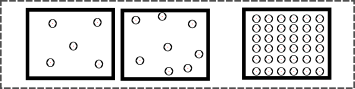

## Obtain the pole of innacessibility

### Load geojson containing the generated tile during the tessellation process

In [ ]:
import os
import geopandas as gpd
from shapely.geometry import Point
from google.colab import files

# --- Upload tessellation polygon file ---
print("Please upload your tessellation GeoJSON file (e.g., SLIC, basins, o what you prefer!)...")
uploaded = files.upload()
tessellation_path = list(uploaded.keys())[0]

# Read GeoJSON into GeoDataFrame
tessellation_gdf = gpd.read_file(tessellation_path)

# Optional: enforce a specific CRS (e.g., EPSG:32618)
tessellation_gdf = tessellation_gdf.to_crs(epsg=32618)

print(f"✅ Tessellation loaded successfully: {tessellation_path}")
print(f"🧩 Number of polygons: {len(tessellation_gdf)}")



### Compute pole analyses
Here you generate the pole of inaccesibility for each tile in your tessellation, being exported as a geojson file. You can edit it on QGIS or another GIS Software to keep o remove specific points as your convenience.
In the original paper, we employed the location of each recorder as reference point.

In [ ]:
# --- Compute pole of inaccessibility (approximate center) for each polygon ---
def approximate_pole_of_inaccessibility(polygon):
    return polygon.representative_point()

# Create GeoDataFrame of pole points
pole_geoms = tessellation_gdf.geometry.apply(approximate_pole_of_inaccessibility)
poles_gdf = gpd.GeoDataFrame(geometry=pole_geoms, crs=tessellation_gdf.crs)

# Build output filename
output_filename = os.path.splitext(tessellation_path)[0] + "_poles.geojson"
poles_gdf.to_file(output_filename, driver="GeoJSON")
print(f"📌 Exported poles to: {output_filename}")

# --- Download result ---
files.download(output_filename)



# STEP V: Raster Sampling with Buffers
After obtaining the sampling points, the user should create buffers around each point and extract raster values, such as landscape heterogeneity, within those buffers (a zonal statistic operation). This should be done for both the sub samplepoints and the reference scenario grid. Note that the researcher should take into account a specific landscape function (e.g., median, mean, entropy), applied to summarize the values within each buffer. This process generates a distribution of the landscape proxy values associated with each sampling point and surrounding areas, enabling further statistical comparisons accounting for heterogeneity.
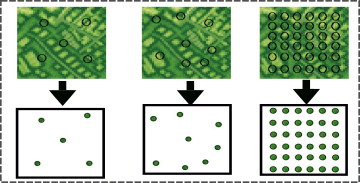


## Install required packages

In [ ]:
# Step 1: Install required packages
!pip install geopandas openpyxl shapely

## Upload and load the tiles GeoJsons

### Upload COMPLETE SCENARIO

In [ ]:
# Step 2: Import libraries
import geopandas as gpd
import pandas as pd
from shapely.ops import nearest_points
from shapely.geometry import Point
from google.colab import files
import os

# Step 3: Upload complete GeoJSON
print("Please upload the COMPLETE GeoJSON file:")
uploaded_complete = files.upload()
complete_path = list(uploaded_complete.keys())[0]
complete_gdf = gpd.read_file(complete_path).to_crs(epsg=32618)
print(f"✅ Complete dataset loaded: {complete_path}")

### Upload tiles from tessellation

In [ ]:
# Step 4: Upload one or more SUBSAMPLE GeoJSON files
print("Please upload one or more SUBSAMPLE GeoJSON files:")
uploaded_subsamples = files.upload()
subsample_files = list(uploaded_subsamples.keys())


### Run zonal analyses and generate table for decision

This chunk will perform a 200m búffer analyses over a landscape proxy raster. Generated table is this:

| Column Name     | Type     | Description                                                                                   |
|-----------------|----------|-----------------------------------------------------------------------------------------------|
| ID              | Integer  | Unique identifier for each sampled point. Automatically assigned (sequentially).             |
| Origin          | String   | Source of the point. `"complete"` indicates full sampling; other values refer to subsamples. |
| X               | Float    | X-coordinate in meters, in EPSG:32618 (UTM Zone 18N, WGS84).                        |
| Y               | Float    | Y-coordinate in meters, same projection (EPSG:32618).                             |
| L_proxy_mean    | Float    | Mean value of the landscape proxy within a 200-meter buffer around each point, in this case               |


Please, note that you can change the buffer and the epsg in the first lines of the code.

In [ ]:
from google.colab import files
import geopandas as gpd
import pandas as pd
import numpy as np
import rasterio
import rasterio.mask
from shapely.geometry import mapping
import os

# --- Upload landscape proxy raster ---
print("Please upload the landscape proxy raster (.tif):")
uploaded_raster = files.upload()
raster_path = list(uploaded_raster.keys())[0]

# --- Constants ---
buffer_radius = 200  # meters
epsg_code = 32618

# --- Process complete points ---
complete_gdf = complete_gdf.to_crs(epsg=epsg_code)
complete_gdf["geometry_buffer"] = complete_gdf.geometry.buffer(buffer_radius)
complete_means = []

with rasterio.open(raster_path) as src:
    for geom in complete_gdf["geometry_buffer"]:
        try:
            out_image, _ = rasterio.mask.mask(src, [mapping(geom)], crop=True)
            out_image = out_image[0]
            valid = out_image[out_image != src.nodata]
            mean_val = float(np.mean(valid)) if valid.size > 0 else np.nan
        except:
            mean_val = np.nan
        complete_means.append(mean_val)

complete_gdf["L_proxy_mean"] = complete_means
complete_gdf["Origin"] = "complete"
complete_gdf["X"] = complete_gdf.geometry.x
complete_gdf["Y"] = complete_gdf.geometry.y
complete_gdf.drop(columns="geometry_buffer", inplace=True)

# --- Process subsample files ---
results = []
for path in subsample_files:
    gdf = gpd.read_file(path).to_crs(epsg=epsg_code)
    gdf["geometry_buffer"] = gdf.geometry.buffer(buffer_radius)

    means = []
    with rasterio.open(raster_path) as src:
        for geom in gdf["geometry_buffer"]:
            try:
                out_image, _ = rasterio.mask.mask(src, [mapping(geom)], crop=True)
                out_image = out_image[0]
                valid = out_image[out_image != src.nodata]
                mean_val = float(np.mean(valid)) if valid.size > 0 else np.nan
            except:
                mean_val = np.nan
            means.append(mean_val)

    gdf["L_proxy_mean"] = means
    gdf["Origin"] = os.path.splitext(os.path.basename(path))[0]
    gdf["X"] = gdf.geometry.x
    gdf["Y"] = gdf.geometry.y
    gdf.drop(columns="geometry_buffer", inplace=True)
    results.append(gdf)

# --- Combine all ---
final_gdf = pd.concat([complete_gdf] + results, ignore_index=True)

# --- Generate ID column ---
final_gdf = final_gdf.reset_index(drop=True)
final_gdf["ID"] = final_gdf.index + 1

# --- Final export ---
columns = ["ID", "Origin", "X", "Y", "L_proxy_mean"]
final_df_export = final_gdf[columns]

output_excel = "Landscape_Means.xlsx"
final_df_export.to_excel(output_excel, index=False)
files.download(output_excel)

print("✅ Excel file generated and downloaded without distance column.")


# STEP VI: Statistical Comparison
Using the obtained values distribution, the next step consists in to compare the distribution of raster values from each sub sample (P) to the full reference dataset (Q). Here, there are two answer to respond using an specific metric:
1- Does the tessellated design resembles the full grid scenario?
to answer this question, the Kolmogorov-Smirnov (KS) test can be used to determine whether the sub samplestatistically resembles the full distribution. And,
2- If so, how much?
To answer this question, is employed the Wasserstein distance. This distance allows to quantify the magnitude of difference between distributions. Please see the Supplementary information S8 for further details.

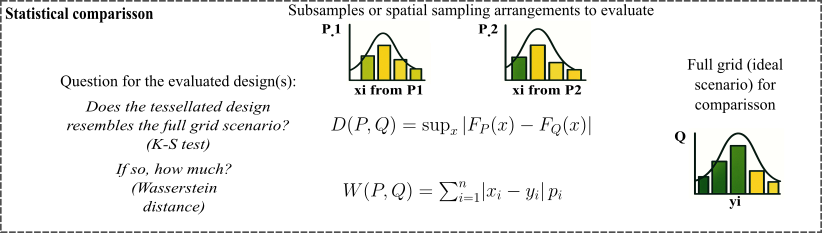

## Install R environment and required packages
You can change the Ncpus parameter, according to the number of cpus of your colab session (This take around 5 minutes).
You can find information regarding ggpubr here:

https://cran.r-project.org/web/packages/ggpubr/index.html

https://rpkgs.datanovia.com/ggpubr/




In [ ]:
# Installing the R essentials and setting up R in Colab for the user
!apt-get install -y libgdal-dev libproj-dev libgeos-dev libudunits2-dev
!R -e "Ncpus <- parallel::detectCores(); install.packages(c('tidyverse', 'ggpubr', 'openxlsx', 'readxl'), dependencies=TRUE, Ncpus=96)"



## Upload your excel file containing landscape and location data
This was obtained from the inmediatly previouly subsection.

In [ ]:
from google.colab import files

print("📁 Please upload the Excel file with landscape metrics:")
uploaded = files.upload()
excel_file = list(uploaded.keys())[0]
#activate R Environment
%load_ext rpy2.ipython
# Pass the file name to R
import rpy2.robjects as robjects
robjects.globalenv['r_excel_path'] = excel_file



## Perform the analsyses

In [ ]:
%%R
library(tidyverse)
library(ggpubr)
library(openxlsx)
library(readxl)

# Define file paths (from Python)
excel_file <- r_excel_path
output_pdf <- "Comparative_Plots_Lproxy_mean_POLYPOLES_ALLTOGETHER.pdf"
output_excel <- "Comparative_Stats_Lproxy_mean_POLYPOLES_ALLTOGETHER.xlsx"

# Load data
df <- read_excel(excel_file)

# Preprocessing
df_filtered <- df %>% filter(!is.na(L_proxy_mean))
df_filtered <- df_filtered %>% mutate(Locality = "All", Tessell = Origin, Procedence = "Examinated")

localities <- unique(df_filtered$Locality)
pdf_opened <- FALSE

# Results init
statistical_results <- data.frame(
  Locality = character(),
  Method = character(),
  Procedence = character(),
  KS_statistic = numeric(),
  KS_p_value = numeric(),
  Wasserstein = numeric(),
  stringsAsFactors = FALSE
)

for (loc in localities) {
  df_loc <- df_filtered %>% filter(Locality == loc)
  full_vals <- df_loc %>% filter(Tessell == "complete") %>% pull(L_proxy_mean)

  for (method in unique(df_loc$Tessell)) {
    if (method == "complete") next

    df_sub <- df_loc %>% filter(Tessell == method)
    if (nrow(df_sub) == 0) next

    sub_vals <- df_sub$L_proxy_mean
    n <- min(length(full_vals), length(sub_vals))
    ks <- ks.test(full_vals, sub_vals)
    wass <- mean(abs(sort(full_vals)[1:n] - sort(sub_vals)[1:n]))

    cat("\n🔎 Method:", method, "\n")
    cat("   KS p-value:", ks$p.value, "\n")
    cat("   KS statistic:", ks$statistic, "\n")
    cat("   Wasserstein:", wass, "\n")

    statistical_results <- rbind(statistical_results, data.frame(
      Locality = loc,
      Method = method,
      Procedence = "Examinated",
      KS_statistic = ks$statistic,
      KS_p_value = ks$p.value,
      Wasserstein = wass
    ))

    # Plotting
    if (!pdf_opened) {
      pdf(output_pdf, width = 14, height = 6)
      pdf_opened <- TRUE
    }

    # Density plot
    p1 <- ggplot(
      df_loc %>% filter(Tessell %in% c("complete", method)),
      aes(x = L_proxy_mean, fill = Tessell)
    ) +
      geom_density(alpha = 0.4) +
      theme_minimal() +
      labs(title = "Density Plot",
           x = "L_proxy_mean", y = "Density", fill = "Tessellation")

    # Q-Q plot
    qq_df <- data.frame(
      complete = sort(full_vals)[1:n],
      sub = sort(sub_vals)[1:n]
    )

    p2 <- ggplot(qq_df, aes(x = complete, y = sub)) +
      geom_point(alpha = 0.6, color = "steelblue") +
      geom_abline(slope = 1, intercept = 0, color = "black", linetype = "dashed") +
      theme_minimal() +
      labs(title = "Q–Q Plot", x = "Complete", y = method)

    combined <- ggarrange(p2, p1, ncol = 2, widths = c(1, 1),
                          labels = c("A", "B"),
                          common.legend = TRUE, legend = "right")

    combined <- annotate_figure(combined,
                                 top = text_grob(paste0(loc, " / ", method, " / Comparison"),
                                                 face = "bold", size = 14))

    print(combined)
  }
}

if (pdf_opened) {
  dev.off()
  cat("\n✅ PDF with all plots generated: ", output_pdf, "\n")
}

# Export results to Excel
write.xlsx(statistical_results, output_excel)
cat("\n Summary statistics exported to:", output_excel, "\n")


## Download the files

In [ ]:
from google.colab import files

files.download("Comparative_Plots_Lproxy_mean_POLYPOLES_ALLTOGETHER.pdf")
files.download("Comparative_Stats_Lproxy_mean_POLYPOLES_ALLTOGETHER.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# STEP VII: TAKE THE DECISION

## Interpretation Guide: Selecting the Optimal Spatial Arrangement

The following table summarizes the **distributional similarity** between each subsampling method and the full (complete) dataset, based on two complementary metrics:

- **Kolmogorov–Smirnov (KS) test**: evaluates whether two samples come from the same distribution.

- **Wasserstein distance**: quantifies the average difference (displacement) between the two distributions.

| Column         | Description |
|----------------|-------------|
| `Method`       | The name of the subsampling strategy (e.g., SLIC, Landcover, Basins, Halfbasins). |
| `KS_statistic` | The maximum distance between the cumulative distributions of the subsample and the complete dataset. Smaller values = more similar. |
| `KS_p_value`   | If **p > 0.05**, we **fail to reject** the null hypothesis: the distributions are not significantly different. |
| `Wasserstein`  | The average “cost” to morph one distribution into the other. Smaller values = better alignment. |

---

## Recommendation Strategy:

To select the **best spatial arrangement**:

1. **Prefer methods with the highest p-value** (preferably > 0.05).
2. Among those, **choose the one with the lowest Wasserstein distance**.
3. If all methods are statistically similar (e.g., all p > 0.05), then Wasserstein becomes the main decision factor.

---

## Example Interpretation:

Imagine this:
- All p-values are above 0.05 → all subsampling methods show statistically similar distributions to the full dataset.
- However, is the **BASINS method** the one that exhibit the **lowest Wasserstein distance**, suggesting it best captures the landscape proxy heterogeneity.

**Conclusion**: The BASINS-based spatial subsampling is the most representative of the full dataset in this case.
